In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import salem
import numpy as np
import geopandas as gpd
from dask.distributed import Client
import dask.dataframe as dd
import cfgrib

In [2]:
dataset_path = '/media/scottcha/E1/Data/RawWeatherData/gfs/15-16/Washington'
region_path = '../../Data'

In [3]:
#set number of workers i'm using 14 on my 16 thread machine
client=Client(n_workers=14, threads_per_worker=1)
client

Client Scheduler: tcp://127.0.0.1:45631 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 14 Memory: 50.55 GB


In [3]:
gfs_levels = ['unknown',
            'surface',
            'isobaricInhPa', 
            'meanSea',
            'depthBelowLandLayer',
            'heightAboveGround',
            'heightAboveGroundLayer',
            'tropopause',
            'maxWind',
            'heightAboveSea',
            'isothermZero',
            'pressureFromGroundLayer',
            'sigmaLayer',
            'sigma',
            'potentialVorticity']

In [6]:
#need to open one with parallel=False to get around a bug in cfgrib
#if using parallel=True you need to make at least 1 call with = False first to initialize cfgrib
#open all the files for a single season at surface level (multiple levels aren't supported)
#in rare events some files are corrupt, missing data or entirely missing
#for a single hourly model its liekly not a big deal as we quickly aggregate the 
#timeseries to daily values (min, avg, max) but its worth being aware of
ds = xr.open_mfdataset(dataset_path + '/gfs.0p25.2015110100.f0*.grib2.spasub.chamberlin390935', engine='cfgrib', combine='nested', concat_dim=['step'], parallel=False, backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface'}})

In [9]:
#open all the datasets
#we need to do this multiple times so that we capture all levels represnted as they are using different dims
tmp_ds = []

for i in range(len(gfs_levels)):
    l = gfs_levels[i]
    print('Opening Level ' + gfs_levels[i])    
    #currently we only open the first 24 hours of forecasts though dataset extends to 84 hours
    #as we expand the lenght of the prediction window we'll need to open more and process more data
    #and figure out how to handle the overlapping dims on the date
    tmp_ds.append(xr.open_mfdataset(dataset_path + '/gfs.0p25.201*00.f0[0-2]*.grib2.spasub.chamberlin390935', engine='cfgrib', combine='nested', concat_dim='time', parallel=True, backend_kwargs={'filter_by_keys': {'typeOfLevel': l}}))
    tmp_ds[i] = tmp_ds[i].where(tmp_ds[i].step < np.timedelta64(1, 'D'), drop=True)
    tmp_ds[i].attrs['Level'] = gfs_levels[i]

Opening Level unknown


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:58922 remote=tcp://127.0.0.1:37907>


Opening Level surface
Opening Level isobaricInhPa
Opening Level meanSea
Opening Level depthBelowLandLayer
Opening Level heightAboveGround
Opening Level heightAboveGroundLayer
Opening Level tropopause
Opening Level maxWind
Opening Level heightAboveSea
Opening Level isothermZero
Opening Level pressureFromGroundLayer
Opening Level sigmaLayer
Opening Level sigma
Opening Level potentialVorticity


In [10]:
def get_variables(ds):
    #find all variables in the data set and their descriptions
    variables = []
    i = 0
    for var in list(ds.data_vars.keys()):
        variables.append((i, var,ds[var].attrs['GRIB_name']))
        i += 1

    return variables

In [12]:
#Read in all avy region shapes and metadata
regions_df = gpd.read_file(region_path + '/USAvalancheRegions.geojson')
#filter to just the ones where we have lables for training
training_regions_df = regions_df[regions_df['is_training']==True].copy()
training_regions_df

,name,center,center_link,timezone,center_id,state,is_training,color,link,geometry
18,Aspen Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.91164 39.58375, -106.94518 39.5..."
19,Front Range Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-105.46760 39.03134, -105.32958 39.0..."
20,Grand Mesa Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-108.19110 39.28692, -108.26556 39.1..."
21,Gunnison Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.91731 38.99704, -106.94591 39.0..."
22,North San Juan Mountains,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.29307 37.66569, -106.26690 37.7..."
23,Sangre de Cristo Range,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-105.67377 38.30698, -105.73780 38.3..."
24,Sawatch Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.13722 39.36625, -106.14642 39.3..."
25,South San Juan Mountains,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.29307 37.66569, -106.35130 37.6..."
26,Steamboat Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#f4e500,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.90587 39.95837, -106.91619 40.0..."
27,Vail Summit Zone,Colorado Avalanche Information Center,https://avalanche.state.co.us/,America/Denver,CAIC,CO,True,#ff9933,http://avalanche.state.co.us/forecasts/backcou...,"POLYGON ((-106.14495 39.96442, -106.17302 39.9..."


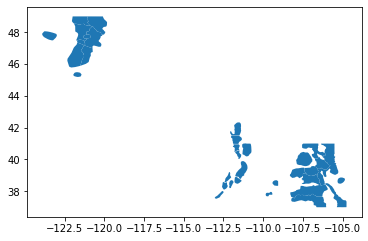

In [13]:
training_regions_df.geometry.plot()

In [14]:
#lon needs to be 0-360
training_regions_df.loc[:,'geometry'] = training_regions_df.translate(360,0)

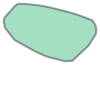

In [15]:
training_regions_df['geometry'][49]

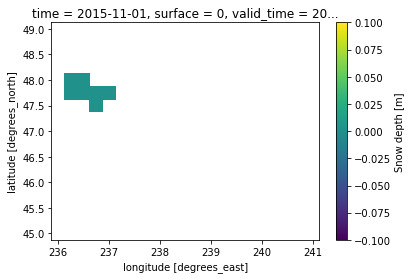

In [16]:
ds.salem.roi(geometry=training_regions_df['geometry'][49]).sde[0].plot()

In [17]:
#filter to just NWAC for now as grib is only Washington/Norther Oregon
training_regions_df = training_regions_df[training_regions_df['center']=='Northwest Avalanche Center']

In [18]:
training_regions_df.reset_index(drop=True, inplace=True)

In [19]:
tmp_ds[1]

<xarray.Dataset>
Dimensions:     (latitude: 17, longitude: 21, time: 1270)
Coordinates:
    surface     int64 0
  * latitude    (latitude) float64 45.0 45.25 45.5 45.75 ... 48.5 48.75 49.0
  * longitude   (longitude) float64 236.0 236.2 236.5 ... 240.5 240.8 241.0
    valid_time  (time) datetime64[ns] 2015-11-01T03:00:00 ... 2016-04-30T12:00:00
    step        (time) timedelta64[ns] 03:00:00 06:00:00 ... 09:00:00 12:00:00
  * time        (time) datetime64[ns] 2015-11-01 2015-11-01 ... 2016-04-30
Data variables:
    gust        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    hindex      (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    sp          (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    orog        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    t           (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    sdwe        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    sde         (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    pevpr       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    cpofp       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    wilt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    fldcp       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    SUNSD       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    lftx        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    cape        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    cin         (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    4lftx       (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    hpbl        (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    lsm         (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
    siconc      (time, latitude, longitude) float32 dask.array<chunksize=(1, 17, 21), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-03-01T16:01:05 GRIB to CDM+CF via cfgrib-0....
    Level:                   surface

In [20]:
#filters the dataset based on the shape defined in the regions dataset (geometry column)
#then maniupulates th dimensions to get the dataset close to a multivariate timeseries ml format 
#though we want to stay in xarray as long as possible so keepign the lat/lon dimensions seperate for now
def filter(regions, ds, level_name):
    result = {}
    
    for _, row in regions.iterrows():
        print("Calculating region: " + row['name'])
        tmp_df = ds.salem.subset(geometry=row['geometry']).salem.roi(geometry=row['geometry'])
        tmp_df = tmp_df.chunk({'time': -1}).interpolate_na(dim='time')
        print("Formatting for ML")
       
        tmp_df = tmp_df.to_array()
        #print(tmp_df)
        if level_name == 'unknown':
            level_name = 'level'
            
        if tmp_df[level_name].values.size == 1:
            tmp_df = tmp_df.drop(level_name)
            tmp_df = tmp_df.rename({'variable':'var'})
        else:
            tmp_df = tmp_df.stack(var=(level_name, 'variable'))
           
        tmp_df.transpose('latitude', 'longitude', 'var', 'time')
       
        result[row['name']] = tmp_df
    return result

In [21]:
#main method to take the raw gfs forcast data and convert it to a time series
def calculate_values(regions, data, interpolate=True):
    results = []
    for d in data:
        level = d.attrs['Level']
        #variables we'll maintain when moving from hourly to daily dataset
        min_name_dict = {}
        max_name_dict = {}
        avg_name_dict = {}
        print("Calcualting Variables")
        for k in d.data_vars.keys():
            min_name_dict[k] = 'min_' + k
            max_name_dict[k] = 'max_' + k
            avg_name_dict[k] = 'avg_' + k
            
        print("Reampling")
        resampled_ds = d.resample(time='1d')
        min_1day = resampled_ds.min().rename(min_name_dict)
        max_1day= resampled_ds.max().rename(max_name_dict)
        avg_1day = resampled_ds.mean().rename(avg_name_dict)
        
        print("Merging")
        merged_ds = xr.merge([min_1day, max_1day, avg_1day])
        
        if interpolate:
            print("Interpolating")
            #interpolate the data to try and make it more applicable to the correct spaces within regions 
            #and less applicable on the boarders of the region
            new_lon = np.linspace(merged_ds.longitude[0], merged_ds.longitude[-1], merged_ds.dims['longitude'] * 4)
            new_lat = np.linspace(merged_ds.latitude[0], merged_ds.latitude[-1], merged_ds.dims['latitude'] * 4)
            interpolated_ds = merged_ds.interp(latitude=new_lat, longitude=new_lon)
        else:
            interpolated_ds = merged_ds
        
        print("Region Filtering")
        results.append(filter(regions, interpolated_ds, level))
    return results

In [233]:
result = calculate_values(training_regions_df, tmp_ds)

Calcualting Variables
Reampling


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Merging
Interpolating
Region Filtering
Calculating region: Mt Hood
Formatting for ML
<xarray.DataArray 'stack-d16d1a244330dbda654acdeb542093e5' (variable: 30, time: 182, latitude: 5, longitude: 8)>
dask.array<stack, shape=(30, 182, 5, 8), dtype=float32, chunksize=(1, 182, 5, 8), chunktype=numpy.ndarray>
Coordinates:
    level      int64 0
  * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
  * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
  * variable   (variable) <U9 'min_u' 'min_v' 'min_VRATE' ... 'avg_tcc' 'avg_gh'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: Olympics
Formatting for ML
<xarray.DataArray 'stack-f5f37d9bdd2d4e6d8501e747eaf30b82' (variable: 30, time: 182, latitude: 10, longitude: 15)>
dask.array<stack, shape=(30, 182, 10, 15), dtype=float32, chunksize=(1, 182, 10, 15), chunktype=numpy.ndarray>
Coordinates:
    leve

Formatting for ML
<xarray.DataArray 'stack-118f12a495aabd78c8de0ec61c12f098' (variable: 57, time: 182, latitude: 6, longitude: 8)>
dask.array<stack, shape=(57, 182, 6, 8), dtype=float32, chunksize=(1, 182, 6, 8), chunktype=numpy.ndarray>
Coordinates:
    surface    int64 0
  * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude   (latitude) float64 47.21 47.27 47.33 47.39 47.45 47.51
  * longitude  (longitude) float64 238.3 238.4 238.5 238.5 ... 238.7 238.7 238.8
  * variable   (variable) <U10 'min_gust' 'min_hindex' ... 'avg_siconc'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: Stevens Pass
Formatting for ML
<xarray.DataArray 'stack-0525b33f58b3b7398a64604032ae9ad0' (variable: 57, time: 182, latitude: 5, longitude: 7)>
dask.array<stack, shape=(57, 182, 5, 7), dtype=float32, chunksize=(1, 182, 5, 7), chunktype=numpy.ndarray>
Coordinates:
    surface    int64 0
  * time       (time) datetime64[ns] 2015-11-01 2015-11-

Formatting for ML
<xarray.DataArray 'stack-4f6a25d0205b03899220dd253eab0a7e' (variable: 18, time: 182, isobaricInhPa: 26, latitude: 23, longitude: 19)>
dask.array<stack, shape=(18, 182, 26, 23, 19), dtype=float32, chunksize=(1, 182, 26, 23, 19), chunktype=numpy.ndarray>
Coordinates:
  * time           (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 ... 70 50 30 20 10
  * latitude       (latitude) float64 47.03 47.09 47.15 ... 48.22 48.28 48.34
  * longitude      (longitude) float64 238.8 238.8 238.9 ... 239.7 239.8 239.9
  * variable       (variable) <U8 'min_gh' 'min_t' ... 'avg_v' 'avg_absv'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: WA Cascades East, North
Formatting for ML
<xarray.DataArray 'stack-3d7373bffc04ed681c64187f935bf1fb' (variable: 18, time: 182, isobaricInhPa: 26, latitude: 20, longitude: 21)>
dask.array<stack, shape=(18, 182, 26, 20, 21), dtype=float32, ch

<xarray.DataArray 'stack-60c9a65c3d76df2e9525dd334ff8817f' (variable: 6, time: 182, latitude: 18, longitude: 19)>
dask.array<stack, shape=(6, 182, 18, 19), dtype=float32, chunksize=(1, 182, 18, 19), chunktype=numpy.ndarray>
Coordinates:
    meanSea    int64 0
  * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude   (latitude) float64 47.51 47.57 47.63 47.69 ... 48.4 48.46 48.52
  * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 239.1 239.1 239.2
  * variable   (variable) <U9 'min_mslet' 'min_prmsl' ... 'avg_prmsl'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: WA Cascades West, Mt Baker
Formatting for ML
<xarray.DataArray 'stack-c8f2e4635e42c336377ca8cb2224e443' (variable: 6, time: 182, latitude: 10, longitude: 18)>
dask.array<stack, shape=(6, 182, 10, 18), dtype=float32, chunksize=(1, 182, 10, 18), chunktype=numpy.ndarray>
Coordinates:
    meanSea    int64 0
  * time       (time) datetime64[ns] 2015-11-

Formatting for ML
<xarray.DataArray 'stack-c3e2813ad382e22dc8d15dc50e331426' (variable: 6, time: 182, depthBelowLandLayer: 2, latitude: 26, longitude: 17)>
dask.array<stack, shape=(6, 182, 2, 26, 17), dtype=float32, chunksize=(1, 182, 2, 26, 17), chunktype=numpy.ndarray>
Coordinates:
  * time                 (time) datetime64[ns] 2015-11-01 ... 2016-04-30
  * depthBelowLandLayer  (depthBelowLandLayer) int64 0 1
  * latitude             (latitude) float64 45.84 45.9 45.96 ... 47.27 47.33
  * longitude            (longitude) float64 237.7 237.7 237.8 ... 238.6 238.7
  * variable             (variable) <U9 'min_st' 'min_soilw' ... 'avg_soilw'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calcualting Variables
Reampling
Merging
Interpolating
Region Filtering
Calculating region: Mt Hood
Formatting for ML
<xarray.DataArray 'stack-a33260ae97402aac1843f96fe23c317b' (variable: 12, time: 182, latitude: 5, longitude: 8)>
dask.array<stack, shape=(12, 182, 5, 8), dtype=float32, 

Formatting for ML
<xarray.DataArray 'stack-1328e14d3d9dc9c2c71492f4c48e1adf' (variable: 3, time: 182, latitude: 5, longitude: 7)>
dask.array<stack, shape=(3, 182, 5, 7), dtype=float32, chunksize=(1, 182, 5, 7), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGroundLayer  int64 3000
  * time                    (time) datetime64[ns] 2015-11-01 ... 2016-04-30
  * latitude                (latitude) float64 47.63 47.69 47.75 47.81 47.87
  * longitude               (longitude) float64 238.7 238.8 ... 239.0 239.1
  * variable                (variable) <U8 'min_hlcy' 'max_hlcy' 'avg_hlcy'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: WA Cascades East, Central
Formatting for ML
<xarray.DataArray 'stack-fabcd07470e0921b789127c1c61e2fec' (variable: 3, time: 182, latitude: 23, longitude: 19)>
dask.array<stack, shape=(3, 182, 23, 19), dtype=float32, chunksize=(1, 182, 23, 19), chunktype=numpy.ndarray>
Coordinates:
    heightAboveGroundLayer  int64 3000
 

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Merging
Interpolating
Region Filtering
Calculating region: Mt Hood
Formatting for ML
<xarray.DataArray 'stack-765fb525d5995d0ce428edf3f07384ff' (variable: 21, time: 182, latitude: 5, longitude: 8)>
dask.array<stack, shape=(21, 182, 5, 8), dtype=float32, chunksize=(1, 182, 5, 8), chunktype=numpy.ndarray>
Coordinates:
    tropopause  int64 0
  * time        (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude    (latitude) float64 45.24 45.3 45.36 45.42 45.48
  * longitude   (longitude) float64 238.1 238.2 238.2 ... 238.4 238.5 238.5
  * variable    (variable) <U9 'min_pres' 'min_icaht' ... 'avg_v' 'avg_vwsh'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: Olympics
Formatting for ML
<xarray.DataArray 'stack-18a7a740597030b6753918f01dd06c47' (variable: 21, time: 182, latitude: 10, longitude: 15)>
dask.array<stack, shape=(21, 182, 10, 15), dtype=float32, chunksize=(1, 182, 10, 15), chunktype=numpy.ndarray>
Coordinates:
    tropopause

Formatting for ML
<xarray.DataArray 'stack-e2165a54b64be270e1214e4eda3d5563' (variable: 18, time: 182, latitude: 6, longitude: 8)>
dask.array<stack, shape=(18, 182, 6, 8), dtype=float32, chunksize=(1, 182, 6, 8), chunktype=numpy.ndarray>
Coordinates:
    maxWind    int64 0
  * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude   (latitude) float64 47.21 47.27 47.33 47.39 47.45 47.51
  * longitude  (longitude) float64 238.3 238.4 238.5 238.5 ... 238.7 238.7 238.8
  * variable   (variable) <U9 'min_pres' 'min_icaht' ... 'avg_v' 'avg_t'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: Stevens Pass
Formatting for ML
<xarray.DataArray 'stack-dda37fdd638d6078085eb3fbc20f27cd' (variable: 18, time: 182, latitude: 5, longitude: 7)>
dask.array<stack, shape=(18, 182, 5, 7), dtype=float32, chunksize=(1, 182, 5, 7), chunktype=numpy.ndarray>
Coordinates:
    maxWind    int64 0
  * time       (time) datetime64[ns] 2015-11-01 2015-11

Formatting for ML
<xarray.DataArray 'stack-7d5dc826824d83ca88c4ff6868a5aedb' (variable: 9, time: 182, heightAboveSea: 3, latitude: 23, longitude: 19)>
dask.array<stack, shape=(9, 182, 3, 23, 19), dtype=float32, chunksize=(1, 182, 3, 23, 19), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * heightAboveSea  (heightAboveSea) int64 1829 2743 3658
  * latitude        (latitude) float64 47.03 47.09 47.15 ... 48.22 48.28 48.34
  * longitude       (longitude) float64 238.8 238.8 238.9 ... 239.7 239.8 239.9
  * variable        (variable) <U5 'min_t' 'min_u' 'min_v' ... 'avg_u' 'avg_v'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: WA Cascades East, North
Formatting for ML
<xarray.DataArray 'stack-06ea391421eba1d1e26e826489322538' (variable: 9, time: 182, heightAboveSea: 3, latitude: 20, longitude: 21)>
dask.array<stack, shape=(9, 182, 3, 20, 21), dtype=float32, chunksize=(1, 182, 3, 20

Formatting for ML
<xarray.DataArray 'stack-e2f7a0f7c0610bb2af31d676d72fcfd6' (variable: 6, time: 182, latitude: 21, longitude: 13)>
dask.array<stack, shape=(6, 182, 21, 13), dtype=float32, chunksize=(1, 182, 21, 13), chunktype=numpy.ndarray>
Coordinates:
    isothermZero  int64 0
  * time          (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude      (latitude) float64 45.96 46.01 46.07 ... 47.03 47.09 47.15
  * longitude     (longitude) float64 238.5 238.6 238.7 ... 239.1 239.2 239.3
  * variable      (variable) <U6 'min_gh' 'min_r' 'max_gh' ... 'avg_gh' 'avg_r'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: WA Cascades West, Central
Formatting for ML
<xarray.DataArray 'stack-9994ce93102ff226f50fb1204a24dbbe' (variable: 6, time: 182, latitude: 18, longitude: 19)>
dask.array<stack, shape=(6, 182, 18, 19), dtype=float32, chunksize=(1, 182, 18, 19), chunktype=numpy.ndarray>
Coordinates:
    isothermZero  int64 0
  * time      

Formatting for ML
<xarray.DataArray 'stack-a7e860063c991d5d24edeb9e48316e01' (variable: 15, time: 182, latitude: 10, longitude: 18)>
dask.array<stack, shape=(15, 182, 10, 18), dtype=float32, chunksize=(1, 182, 10, 18), chunktype=numpy.ndarray>
Coordinates:
    pressureFromGroundLayer  int64 3000
  * time                     (time) datetime64[ns] 2015-11-01 ... 2016-04-30
  * latitude                 (latitude) float64 48.46 48.52 48.58 ... 48.94 49.0
  * longitude                (longitude) float64 238.0 238.0 ... 239.0 239.0
  * variable                 (variable) <U5 'min_t' 'min_r' ... 'avg_u' 'avg_v'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: WA Cascades West, South
Formatting for ML
<xarray.DataArray 'stack-3d4d7bf680fda55db07f72b35c3df218' (variable: 15, time: 182, latitude: 26, longitude: 17)>
dask.array<stack, shape=(15, 182, 26, 17), dtype=float32, chunksize=(1, 182, 26, 17), chunktype=numpy.ndarray>
Coordinates:
    pressureFromGroun

Merging
Interpolating
Region Filtering
Calculating region: Mt Hood
Formatting for ML
<xarray.DataArray 'stack-c562df74ef7721a622c1b560087b7c15' (variable: 18, time: 182, latitude: 5, longitude: 8)>
dask.array<stack, shape=(18, 182, 5, 8), dtype=float32, chunksize=(1, 182, 5, 8), chunktype=numpy.ndarray>
Coordinates:
    sigma      int64 1
  * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
  * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
  * variable   (variable) <U6 'min_t' 'min_pt' 'min_r' ... 'avg_v' 'avg_w'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: Olympics
Formatting for ML
<xarray.DataArray 'stack-803fb22cddaf6ca31416dc994b536e58' (variable: 18, time: 182, latitude: 10, longitude: 15)>
dask.array<stack, shape=(18, 182, 10, 15), dtype=float32, chunksize=(1, 182, 10, 15), chunktype=numpy.ndarray>
Coordinates:
    sigma     

Formatting for ML
<xarray.DataArray 'stack-ef568e114701e0cb0784d1d5546500b6' (variable: 18, time: 182, potentialVorticity: 2, latitude: 6, longitude: 8)>
dask.array<stack, shape=(18, 182, 2, 6, 8), dtype=float32, chunksize=(1, 182, 2, 6, 8), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 2015-11-01 ... 2016-04-30
  * potentialVorticity  (potentialVorticity) int64 2 2147486
  * latitude            (latitude) float64 47.21 47.27 47.33 47.39 47.45 47.51
  * longitude           (longitude) float64 238.3 238.4 238.5 ... 238.7 238.8
  * variable            (variable) <U8 'min_u' 'min_v' ... 'avg_pres' 'avg_vwsh'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 
Calculating region: Stevens Pass
Formatting for ML
<xarray.DataArray 'stack-3a1c0d8518cab4c21c5bc61dc1ac590d' (variable: 18, time: 182, potentialVorticity: 2, latitude: 5, longitude: 7)>
dask.array<stack, shape=(18, 182, 2, 5, 7), dtype=float32, chunksize=(1, 182, 2, 5, 7), chunktyp

In [224]:
result

<xarray.DataArray 'stack-d16d1a244330dbda654acdeb542093e5' (var: 30, time: 182, latitude: 5, longitude: 8)>
dask.array<stack, shape=(30, 182, 5, 8), dtype=float32, chunksize=(1, 182, 5, 8), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
  * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
  * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
  * var        (var) <U9 'min_u' 'min_v' 'min_VRATE' ... 'avg_tcc' 'avg_gh'
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84

In [234]:
#take the resulting data from filtering/interpolating and reorganize it a bit to make it
#easier to work with in subsequent steps (i.e., by region)
#also stores the aggregate list of features/variables for later use when 
#the data is all merged together 
by_region = {}
variables = []
for i in range(len(result)):
    first_region = True
    for k in result[i].keys():
        if i == 0:            
            by_region[k] = []
            
        if first_region:
            variables += result[i][k].coords['var'].values.tolist()
            first_region = False
        
        by_region[k].append(result[i][k].transpose('latitude', 'longitude', 'var', 'time'))
    

In [231]:
by_region['Mt Hood']

[<xarray.DataArray 'stack-d16d1a244330dbda654acdeb542093e5' (latitude: 5, longitude: 8, var: 30, time: 182)>
 dask.array<transpose, shape=(5, 8, 30, 182), dtype=float32, chunksize=(5, 8, 1, 182), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
   * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
   * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
   * var        (var) <U9 'min_u' 'min_v' 'min_VRATE' ... 'avg_tcc' 'avg_gh'
 Attributes:
     pyproj_srs:  +units=m +proj=latlong +datum=WGS84 ,
 <xarray.DataArray 'stack-346e9d64d2a0d1fb9c292781416a003a' (latitude: 5, longitude: 8, var: 57, time: 182)>
 dask.array<transpose, shape=(5, 8, 57, 182), dtype=float32, chunksize=(5, 8, 1, 182), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
   * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
   * longitude  (longitu

In [284]:
len(variables)

735

In [143]:
get_variables(tmp_ds[1])

[(0, 'gust', 'Wind speed (gust)'),
 (1, 'hindex', 'Haines Index'),
 (2, 'sp', 'Surface pressure'),
 (3, 'orog', 'Orography'),
 (4, 't', 'Temperature'),
 (5, 'sdwe', 'Water equivalent of accumulated snow depth (deprecated)'),
 (6, 'sde', 'Snow depth'),
 (7, 'pevpr', 'Potential evaporation rate'),
 (8, 'cpofp', 'Percent frozen precipitation'),
 (9, 'wilt', 'Wilting Point'),
 (10, 'fldcp', 'Field Capacity'),
 (11, 'SUNSD', 'Sunshine Duration'),
 (12, 'lftx', 'Surface lifted index'),
 (13, 'cape', 'Convective available potential energy'),
 (14, 'cin', 'Convective inhibition'),
 (15, '4lftx', 'Best (4-layer) lifted index'),
 (16, 'hpbl', 'Planetary boundary layer height'),
 (17, 'lsm', 'Land-sea mask'),
 (18, 'siconc', 'Sea ice area fraction')]

In [245]:
#If we need to look up an index in to numpy for a variable this is how you do it
variables.index('avg_sde')

74

In [236]:
by_region['Mt Hood']

[<xarray.DataArray 'stack-d16d1a244330dbda654acdeb542093e5' (latitude: 5, longitude: 8, var: 30, time: 182)>
 dask.array<transpose, shape=(5, 8, 30, 182), dtype=float32, chunksize=(5, 8, 1, 182), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
   * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
   * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
   * var        (var) <U9 'min_u' 'min_v' 'min_VRATE' ... 'avg_tcc' 'avg_gh'
 Attributes:
     pyproj_srs:  +units=m +proj=latlong +datum=WGS84 ,
 <xarray.DataArray 'stack-346e9d64d2a0d1fb9c292781416a003a' (latitude: 5, longitude: 8, var: 57, time: 182)>
 dask.array<transpose, shape=(5, 8, 57, 182), dtype=float32, chunksize=(5, 8, 1, 182), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 2015-11-01 2015-11-02 ... 2016-04-30
   * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
   * longitude  (longitu

In [237]:
#TODO convert this to a dict to make lookup by region easier later
#Warning: this method takes a long time as it will force most of the 
#dask tasks we've been batching up to execute in order to move to numpy dataset
np_result = []
for k in by_region.keys():
    #TODO: eventually we should do these two steps directly in xarray though they both seem to fail
    #right now so doing in np as a workaround
    tmp = np.concatenate(by_region[k], axis=2)
    np_result.append(tmp)
   
    

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [247]:
np_result[0].shape[3]

182

In [251]:
#pad the time value
#fill forward so that we have 0 for all values up to Nov 1 so that we can select a 180 
#range for every day we are predicting starting around Dec 1
for i in range(len(np_result)):
    r = np_result[i]
    r = np.pad(r, [(0, 0), (0, 0), (0, 0), (365-r.shape[3],0)], mode='constant', constant_values=0)
    np_result[i] = r

In [252]:
np_result[1].shape

(10, 15, 735, 365)

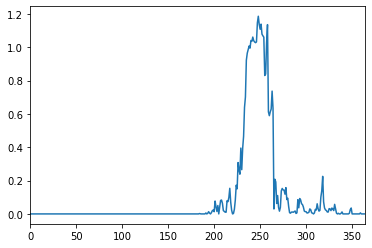

In [246]:
#check that the dataset makes sense after padding (365 days snow depth)
pd.Series(t_pad[2,2,74,:]).plot()

In [281]:
#TODO this needs to be adjusted so that end date always ends on april 30 (i.e., for leapyears)
#create the time dimension so we can move back to xarray
date = np.array('2015-05-02', dtype=np.datetime64)
date_values = date + np.arange(365)

In [297]:
date_values[:10]

array(['2015-05-02', '2015-05-03', '2015-05-04', '2015-05-05',
       '2015-05-06', '2015-05-07', '2015-05-08', '2015-05-09',
       '2015-05-10', '2015-05-11'], dtype='datetime64[D]')

In [307]:
#move back to xarray with our now consolodated data so that we can store it to the disk cache
#while maintaining the labeled dimensions
keys = list(by_region.keys())
xr_results = {}
for i in range(len(keys)):
    xr_results[keys[i]] = xr.DataArray(np_result[i], dims=('latitude', 'longitude', 'var', 'time'), 
                                       coords = {'latitude':by_region[keys[i]][0].latitude.values, #always using 0 as all lat lon for the datasets should be identical
                                                 'longitude':by_region[keys[i]][0].longitude.values,
                                                  'var':variables,
                                                  'time':date_values
                                                 })
    
    

In [319]:
#Store the values to disk
for k in xr_results.keys():
    #TODO: seems to be a bug in xarray handling some fo the data wiht the default netcdf engine it chooses
    #as this throws an error
    #xr_results[k].to_netcdf('/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/Region_' + k + '_15-16.nc')
    
    #this works
    xr_results[k].to_netcdf('/media/scottcha/Data/Temp/GFSFiltered/Region_' + k + '_15-16.nc', engine='h5netcdf')

/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)


In [320]:
#check that the stored data works
mthood = xr.open_dataarray('/media/scottcha/Data/Temp/GFSFiltered/Region_Mt Hood_15-16.nc')

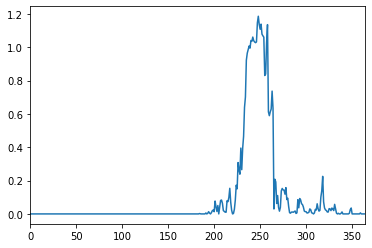

In [328]:
pd.Series(xr_results['Mt Hood'][2][2][74]).plot()

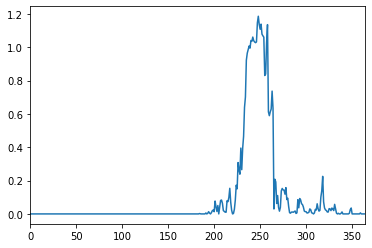

In [329]:
pd.Series(mthood[2][2][74]).plot()

In [4]:
processed_path = '/media/scottcha/Data/Temp/GFSFiltered/'

In [14]:
import glob
file_names = glob.glob(processed_path + '/Region*.nc')

processed_da = {}

for f in file_names:
    name_parts = f.split('_')
    
    processed_da[name_parts[1]] = xr.open_dataarray(f)

In [15]:
processed_da.keys()

dict_keys(['Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass', 'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South', 'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South'])

In [72]:
processed_da['Mt Hood']

<xarray.DataArray (latitude: 5, longitude: 8, var: 735, time: 365)>
[10731000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
  * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
  * time       (time) datetime64[ns] 2015-05-02 2015-05-03 ... 2016-04-30
  * var        (var) object 'min_u' 'min_v' ... "(2147486, 'avg_vwsh')"

In [16]:
#get the labels
path_to_labels = '/media/scottcha/E1/Data/OAPMLData/CleanedForecastsNWAC_CAIC_UAC.V1.csv'

In [33]:
labels = pd.read_csv(path_to_labels, low_memory=False)
date_col = 'Day1Date'
region_col = 'UnifiedRegion'

In [32]:
labels['UnifiedRegion']

0                           Olympics
1        Cascade Pass - Stevens Pass
2          Cascade Pass - Snoq. Pass
3                            Mt Hood
4               Cascade West - North
                    ...             
22249                  In The Desert
22250                  In The Desert
22251                  In The Desert
22252                  In The Desert
22253                  In The Desert
Name: UnifiedRegion, Length: 22254, dtype: object

In [34]:
labels[[date_col, region_col]].groupby([region_col]).count()

,Day1Date
UnifiedRegion,
Abajo,228
Aspen,740
Cascade East - Central,712
Cascade East - North,568
Cascade East - South,856
Cascade Pass - Snoq. Pass,712
Cascade Pass - Stevens Pass,712
Cascade West - Central,712
Cascade West - North,711


In [63]:
labels[date_col].head()

0    20131211
1    20131211
2    20131211
3    20131211
4    20131211
Name: Day1Date, dtype: int64

In [66]:
#find the timeseries for a date & label
example_label = labels[(labels[date_col] == 20160101) & (labels[region_col]=='Mt Hood')]

In [70]:
example_label['parsed_date'] = pd.to_datetime(example_label[date_col], format='%Y%m%d')

/home/scottcha/anaconda3/envs/pangeo_local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
import datetime
example_label['parsed_date'].iloc[0] + datetime.timedelta(days=-179)

Timestamp('2015-07-06 00:00:00')

In [84]:
#this should be the correct dataset for a single label in a region on a date
processed_da['Mt Hood'].sel(time = slice(example_label['parsed_date'].iloc[0] + datetime.timedelta(days=-179), example_label['parsed_date'].iloc[0]))

<xarray.DataArray (latitude: 5, longitude: 8, var: 735, time: 180)>
[5292000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 45.24 45.3 45.36 45.42 45.48
  * longitude  (longitude) float64 238.1 238.2 238.2 238.3 ... 238.4 238.5 238.5
  * time       (time) datetime64[ns] 2015-07-06 2015-07-07 ... 2016-01-01
  * var        (var) object 'min_u' 'min_v' ... "(2147486, 'avg_vwsh')"

In [ ]:
#TODO:
#drop isnan once back in xr
#cleaned_result = np_result[~np.isnan(np_result).all(axis=(1,2))]

In [46]:
#format each series in to the correct training format (region/day, variable, timestep)
#mthood_np = mthood_df.stack(lat_lon_level=('latitude','longitude')).to_array().stack(var=('isobaricInhPa','variable')).transpose('lat_lon_level', 'var', 'time').values

In [117]:
#This is code to filter to all the potential world avy locations
#avy_regions_shp = salem.read_shapefile('../../GetTrainingData/CreateGlobalAvyRegions/WorldAvyRegionsShapeV2/WorldAvyRegionsV2.shp')
#avy_regions_shp.plot()
#avy_regions_shp2 = avy_regions_shp.translate(360,0)
#avy_regions_shp2[0]
#merged_filtered_ds = merged_interpolated_ds.salem.roi(geometry=avy_regions_shp2[0])
#this is the filtered snowdepths for the first day in the dataset
#merged_filtered_ds.avg_sde[100].plot()

In [ ]:
#TOOD:
#1. Join in labels
#2. figure out how to get in to a ML approach try fastai timeseries
#3. add other dates, levels and regions